This Jupyter Notebook contains an example of hyperparameter tuning for the Linear Thompson Sampling algorithm available in mabe/models/  

This hyperparameter optimization is not performed by an exhaustive search, actually only some specific hyperparameter values are tried and performance in each of the cases is compared. For a more exhaustive search, a randomized search with, for example, scikit-learn, or even a more complex optimization scheme, such as using TPE with Optuna could be tried.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from mabe.models import LinTS
from mabe.simulator import *

sns.set_style('darkgrid')

In [2]:
# Configuration of the simulator
n_users = 200
n_products = 10
n_interactions = 25000

In [3]:
# Product categories
product_categories = ['technology', 'fashion', 'books', 'sports', 'home']

# Generate users and products
users = [generate_user(i, product_categories) for i in range(n_users)]
products_df = generate_products(n_products, product_categories)

In [4]:
n_arms = n_products

In [5]:
vs = [0.1, 0.3, 0.5, 1.0, 2.0, 5.0]

In [6]:
n_runs = 5

In [7]:
rewards_runs = []
regrets_runs = []
for i in range(n_runs):
    policies = {}
    for v in vs:
        policies[f'LinTS_{v}'] = LinTS(n_arms=n_arms, context_dim=10, v=v)
    cum_reward = [0] * len(policies)
    cum_regret = [0] * len(policies)
    rewards = [[0] for _ in range(len(policies))]
    regrets = [[0] for _ in range(len(policies))]
    for i in range(n_interactions):
        user = np.random.choice(users)
        start = pd.Timestamp('2025-01-01 00:00:00')
        end = pd.Timestamp('2025-12-31 23:59:59')
        timestamp = start + pd.to_timedelta(np.random.uniform(0, 1) * (end - start))

        # Create context vectors
        context_df = products_df.assign(**user)
        context_df = context_df.loc[:, ['age', 'gender', 'preferred_category', 'category']]
        # List of categorical columns
        categorical_cols = ['gender', 'preferred_category', 'category']
        categories = [['M', 'F'], product_categories, product_categories]
        # Create the column transformer
        column_transformer = ColumnTransformer(
            transformers=[
                ('onehot', OneHotEncoder(sparse_output=False, categories=categories, drop='first'), categorical_cols)
            ],
            remainder='passthrough'  # or 'passthrough' to keep non-categorical columns
        )
        # Fit and transform the data
        encoded_array = column_transformer.fit_transform(context_df)
        x_contexts = list(encoded_array[:, :, None])

        cat_splits = (['technology', 'sports'], ['fashion', 'books', 'home'])
        interactions = simulate_interactions(user, products_df, timestamp, cat_splits)

        for j, key in enumerate(policies.keys()):
            recommendation = policies[key].select_action(x_contexts)
            product = interactions.iloc[recommendation, 0]
            click = interactions.iloc[recommendation, -1]

            cum_reward[j] += click
            cum_regret[j] += interactions.iloc[:, -1].max() - click
            rewards[j].append(cum_reward[j])
            regrets[j].append(cum_regret[j])

            policies[key].update(recommendation, x_contexts[recommendation], click)
    rewards_runs.append(rewards)
    regrets_runs.append(regrets)

In [8]:
rewards = np.array(rewards_runs).mean(axis=0)
regrets = np.array(regrets_runs).mean(axis=0)

Text(0, 0.5, 'Cumulative reward')

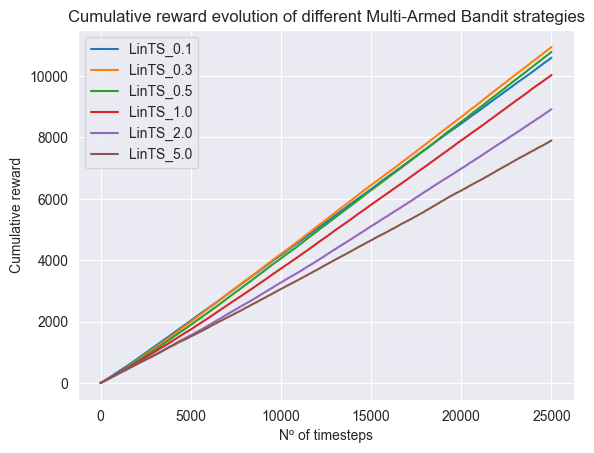

In [9]:
for i, key in enumerate(policies.keys()):
    plt.plot(np.arange(n_interactions+1), rewards[i, :], label=key)
plt.legend()
plt.title('Cumulative reward evolution of different Multi-Armed Bandit strategies')
plt.xlabel('Nº of timesteps')
plt.ylabel('Cumulative reward')

Text(0, 0.5, 'Cumulative regret')

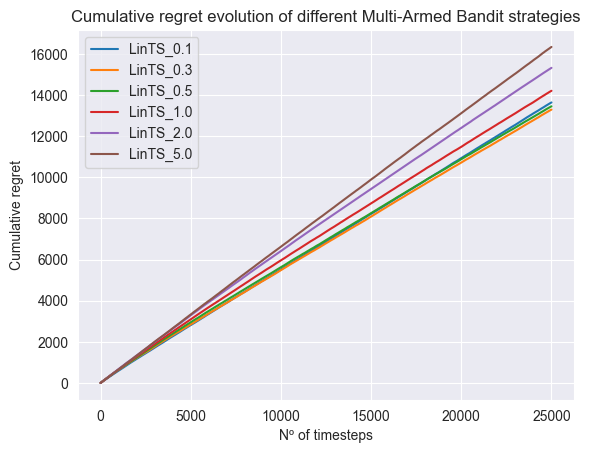

In [10]:
for i, key in enumerate(policies.keys()):
    plt.plot(np.arange(n_interactions+1), regrets[i, :], label=key)
plt.legend()
plt.title('Cumulative regret evolution of different Multi-Armed Bandit strategies')
plt.xlabel('Nº of timesteps')
plt.ylabel('Cumulative regret')

$v$ = 0.3 seems the best value.